*Aprenentatge Computacional*  
- Zakaria Boudich Makran (1672001)

# Pràctica - Google Play Store Apps

En aquesta pràctica s'abordarà la creació d'un model per predir el nombre de descàrregues d'una aplicació mòbil, representat per l'atribut *Installs*. Seguirem una sèrie de passos per assolir aquest objectiu: primer analitzarem les dades, les preprocessarem, escollirem les mètriques adequades i provarem diferents models per tal d'aconseguir el millor resultat.


## 0. Importació de llibreries 

Importem les llibreries necessàries per a la manipulació, visualització i anàlisi de dades ⚙️

In [645]:
# LLIBRERIES PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIES PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PRINCIPAL PER A APRENENTATGE AUTOMÀTIC (scikit-learn)
# SUBMÒDUL PER LA SELECCIÓ I DIVISIÓ DELS DATASETS
from sklearn.model_selection import train_test_split

# SUBMÒDUL PER EINES DE PREPROCESSAMENT
from sklearn.preprocessing import MinMaxScaler

# SUBMÒDUL PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# SUBMÒDUL PER AVALUAR DIFERENTS MODELS
from sklearn.metrics import make_scorer, r2_score

# SUBMÒDUL PER VALIDACIÓ I OPTIMITZACIÓ DE MODELS
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, learning_curve

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder

# LLIBRERIA PER GESTIONAR I MANIPULAR DATES I HORES
from datetime import datetime

# LLIBRERIA PER GESTIONAR ADVERTÈNCIES
import warnings  

# LLIBRERIA PER CONFIGURAR ELS PARÀMETRES DE VISUALITZACIÓ
from matplotlib import rcParams

# FUNCIÓ PER SUPRIMIR ELS WARNINGS
warnings.filterwarnings('ignore')

## 1. Anàlisi exploratòria de dades

En aquest projecte, se’ns proporcionen **dos conjunts de dades**:

**1. Dataset de les aplicacions (Apps):** 📲  
* Conté informació sobre les aplicacions a la Google Play Store, com el nom, la categoria, la valoració mitjana, el nombre d'instal·lacions, el preu, etc.  
* Aquest conjunt de dades ens permet entendre les característiques bàsiques de cada aplicació i el seu rendiment a la botiga.

**2. Dataset de les ressenyes (Reviews):** ⭐ 
* Conté les opinions dels usuaris sobre les aplicacions anteriors. Cada ressenya inclou la valoració que l'usuari ha donat a l'aplicació, comentari de l'usuari, etc. 
* Aquest conjunt de dades és útil per estudiar el sentiment dels usuaris i com les valoracions individuals poden influir en la valoració general de l'aplicació.

Cal dir que, el conjunt de dades *reviews* només cobreix un 10% de les aplicacions presents al conjunt *apps*, a més que moltes de les aplicacions no tenen tan sols un comentari. Això fa inviable integrar els seus atributs al dataset principal, ja que no hi ha suficient informació per a la majoria de les aplicacions. Tot i així, s’ha realitzat una anàlisi bàsica d’aquest conjunt de dades, que es presenta als annexos.  

Per tant, en aquest apartat ens centrarem en una anàlisi exploratòria del dataset *apps*, on descriurem els atributs, identificarem patrons, analitzarem els valors nuls i els valors anòmals.

### 1.1 Descripció dels atributs


In [698]:
apps_data = pd.read_csv("data/aplicacions.csv")
train_data, test_data = train_test_split(apps_data, test_size=0.25, random_state=42)
train_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
6105,"Women""s Health Tips(Breast,Face,Body,weight lose)",HEALTH_AND_FITNESS,4.2,2509,5.0M,"1,000,000+",Free,0,Mature 17+,Health & Fitness,"April 20, 2018",1.8,4.1 and up
8690,Magical Insta DP,PHOTOGRAPHY,NaN,2,5.2M,"1,000+",Free,0,Everyone,Photography,"June 28, 2018",1.1,4.0 and up
898,"Movies by Flixster, with Rotten Tomatoes",ENTERTAINMENT,4.5,653008,16M,"10,000,000+",Free,0,Everyone,Entertainment,"June 20, 2018",9.1.4,4.4 and up
3037,"Hole19: Golf GPS App, Rangefinder & Scorecard",SPORTS,4.4,6106,Varies with device,"100,000+",Free,0,Everyone,Sports,"August 1, 2018",Varies with device,Varies with device
3210,Hotels.com: Book Hotel Rooms & Find Vacation D...,TRAVEL_AND_LOCAL,4.5,260133,Varies with device,"10,000,000+",Free,0,Everyone,Travel & Local,"July 4, 2018",Varies with device,Varies with device


In [647]:
print("El nombre de mostres que tenim a la base de dades és de", train_data.shape[0])
print("El nombre d'atributs que tenim a la base de dades és de", train_data.shape[1])

El nombre de mostres que tenim a la base de dades és de 8130
El nombre d'atributs que tenim a la base de dades és de 13


Es pot veure que disposem de 13 atributs diferents amb un total de 10841 mostres. A continuació, es descriuran els atributs, explicant tant el seu significat com el tipus de dades que contenen.


In [648]:
print("Informació de cada atribut:")
print(train_data.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
Index: 8130 entries, 6105 to 7270
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8130 non-null   object 
 1   Category        8130 non-null   object 
 2   Rating          7035 non-null   float64
 3   Reviews         8130 non-null   object 
 4   Size            8130 non-null   object 
 5   Installs        8130 non-null   object 
 6   Type            8129 non-null   object 
 7   Price           8130 non-null   object 
 8   Content Rating  8129 non-null   object 
 9   Genres          8130 non-null   object 
 10  Last Updated    8130 non-null   object 
 11  Current Ver     8124 non-null   object 
 12  Android Ver     8127 non-null   object 
dtypes: float64(1), object(12)
memory usage: 889.2+ KB
None


La base de dades conté 13 atributs on es descriu les característiques de cada aplicació. A continuació es fa una breu descripció de cada *feature*:

- **App (Objecte):** Nom de l'aplicació.  
- **Category (Objecte):** Categoria de l'aplicació.  
- **Rating (Float64):** Valoració mitjana de l'aplicació (valor de 1 a 5).  
- **Reviews (Objecte):** Nombre de ressenyes que té l'aplicació. 
- **Size (Objecte):** Mida de l'aplicació. Pot incloure unitats de mesura com 'M' o 'k'. Si la mida depèn del dispositiu s'utilitza l'expressió "Varies with devices".
- **Installs (Objecte):** Nombre de descargues de l'aplicació. (Inclou el caràcter +)
- **Type (Objecte):** Si l'aplicació és gratuïta o de pagament.  
- **Content Rating (Objecte):** Classificació per contingut (per exemple, "Tots els públics", "Adolescents", etc.).  
- **Genres (Objecte):** Gèneres de l'aplicació (com "Acció", "Educació", etc.).  
- **Last Updated (Objecte):** La data de l'última actualització de l'aplicació. Es presenta en el format "MMMM DD, YYYY".
- **Price (Objecte):** El preu de l'aplicació (si és de pagament). S'inclou el símbol '$', indicant que el preu esta en dòlars. 
- **Current Ver (Objecte):** Versió actual de l'aplicació.  
- **Android Ver (Objecte):** Versió d'Android compatible amb l'aplicació.



### 1.2. Detecció de valors nuls

En aquest apartat, analitzarem en detall els valors nuls del dataset. 🔍


In [649]:
print(train_data.isnull().sum()[train_data.isnull().sum() > 0])

Rating            1095
Type                 1
Content Rating       1
Current Ver          6
Android Ver          3
dtype: int64


Podem observar l'aparició de valors nuls en els atributs següents: *Rating*, *Type*, *Content Rating*, *Current Ver*, i *Android Ver*. D'aquests atributs el més significatiu és el *Rating*.
A continuació, el que farem és imprimir algunes files del dataset on el *Rating* tingui un valor nul, per veure si aquestes dades faltants tenen algun significat o son a causa d'algun error. 

In [699]:
null_ratings = train_data[train_data['Rating'].isnull()]
print(null_ratings.head().to_string(index=False))

                           App            Category  Rating Reviews Size Installs Type Price Content Rating            Genres      Last Updated Current Ver  Android Ver
              Magical Insta DP         PHOTOGRAPHY     NaN       2 5.2M   1,000+ Free     0       Everyone       Photography     June 28, 2018         1.1   4.0 and up
Painting Lulu DC Super Friends BOOKS_AND_REFERENCE     NaN       7  17M   1,000+ Free     0       Everyone Books & Reference  February 9, 2017         1.2 4.0.3 and up
                      AO-EVENT            BUSINESS     NaN       0  42M     100+ Free     0       Everyone          Business      May 28, 2018       6.2.6   4.1 and up
                   FR Plus 1.6   AUTO_AND_VEHICLES     NaN       4 3.9M     100+ Free     0       Everyone   Auto & Vehicles     July 24, 2018       1.3.6  4.4W and up
          Freedom Christian BF           LIFESTYLE     NaN       0  12M      10+ Free     0       Everyone         Lifestyle February 22, 2016         1.0 4.0.3

Com es pot veure, tot indica que els valors nuls de l'atribut *Rating* son errors a la hora de crear el dataset o per una altre raó que desconeixem, ja que les aplicacions que és mostren, el nombre de ressenyes (*reviews*) és major a zero, però tot i així apareix un valor nul en l'atribut *Rating*. 

### 1.3. Detecció de dades anomals

En aquest apartat, comprovarem que alguns atributs del dataset no continguin valors anòmals (outliers) no detectats inicialment, considerant-ne els resultats principalment pel *preprocessing* dels atributs. S'ha de tenir en compte que no considerarem els valors nuls com a valors anòmals, ja que els hem tractat anteriorment.\
Començarem verificant els atributs que considera la llibreria Pandas com a numèrics, i posteriorment passarem als categòrics. 

**1. Atributs numèrics: 🔢** 
- **Rating:** Verifiquem que no tinguem valors negatius o valors fora del rang [1, 5].

In [651]:
print(f"Rating - Min: {train_data['Rating'].min()}, Max: {train_data['Rating'].max()}")

Rating - Min: 1.0, Max: 19.0


Com podem veure, tot i que no tenim valors negatius, ens aparèixen valors fora del rang [1,5]. Per entrar en l'arrel del problema, visualitzarem les files que contenen valors majors a 5 en l'atribut:

In [652]:
incorrect_ratings = train_data[train_data['Rating'] > 5]
print(incorrect_ratings.to_string(index=False))

                                    App Category  Rating Reviews   Size Installs Type    Price Content Rating            Genres Last Updated Current Ver Android Ver
Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0    3.0M 1,000+     Free    0 Everyone            NaN February 11, 2018       1.0.19  4.0 and up         NaN


La sortida anterior, ens indica que hi ha una fila on els valors dels atributs no estan correctament assignats. Per exemple, veiem que el nombre de descargues de l'aplicació, que en aquest cas és 1000, no està inserit en l'atribut *Installs* (que és on hauria d'estar), sino en l'atribut *Size*. Amb altres atributs d'aquesta fila ens passa el mateix. Com a cas especial, per no veure el mateix error en les comprovacions següents, corregirem manualment aquesta fila:

In [700]:
train_data.loc[10472] = ['Life Made Wi-Fi Touchscreen Photo Frame', 'PHOTOGRAPHY', 1.9, 19.0, '3.0MB', '1,000+', 'Free', "Everyone", '0', 'Photography', 'February 11, 2018', '1.0.19', '4.0 and up']

**2. Atributs categòrics: 🏷️** 

- **Last Updated**: Per aquest atribut, ens assegurarem que les dates segueixin un patró de format bàsic. En aquest cas, que el primer element sigui una paraula per al mes, seguit d’un número per al dia (de 1 o 2 dígits), i un any de quatre dígits. Per aconseguir-ho, ens ajudarem de les expresions regulars. En la sortida imprimirem les dates que no siguin vàlides.

In [654]:
date_pattern = r"^[A-Za-z]+ \d{1,2}, \d{4}$"
invalid_dates = train_data[~train_data["Last Updated"].str.match(date_pattern, na=False)]
print(invalid_dates["Last Updated"])

Series([], Name: Last Updated, dtype: object)


Com que la llista és buida, podem dir que les dates contenides en l'atribut tenen un format bàsic vàlid. A continuació veurem la seva distribució. 

- **Reviews**, **Installs**, **Price**: Tot i que Pandas ha assignat aquests atributs com a categòrics, per la seva naturaleza els podem considerar com a numèrics. Com s'ha fet per l'atribut *Rating*, agafarem el valor mínim de cada atribut per detectar si tenim valors negatius. Com a casos especials, per a trobar el mínim de l'atribut *Installs* i *Price*, abans haurem d'eliminar algun caràcter present en els seus valors. Per exemple, en l'atribut *Price* ens hi pot aparèixer el caràcter "$".

In [655]:
# Convertim "Reviews" a numèric sense modificar el dataframe original
reviews_summary = pd.to_numeric(train_data["Reviews"], errors='coerce').describe()
print(f"Reviews - Min: {reviews_summary['min']}")

# Eliminem el caràcter "+" dels valors de "Installs" sense modificar l'original
installs_cleaned = train_data["Installs"].str.replace('+', '', regex=False)
installs_summary = pd.to_numeric(installs_cleaned, errors='coerce').describe()
print(f"Installs - Min: {installs_summary['min']}")

# Eliminem el caràcter "$" dels valors de "Price" sense modificar l'original
price_cleaned = train_data["Price"].str.replace('$', '', regex=False)
price_summary = pd.to_numeric(price_cleaned, errors='coerce').describe()
print(f"Price - Min: {price_summary['min']}")

Reviews - Min: 0.0
Installs - Min: 0.0
Price - Min: 0.0


Com que el valor mínim per cada atribut és 0, podem dir que no hi tenim valors negatius. 

- **Type** i **Content Rating**: Graficarem la seva distribució i analitzarem dels seus posibles valors si hi ha alguna dada anomala. 

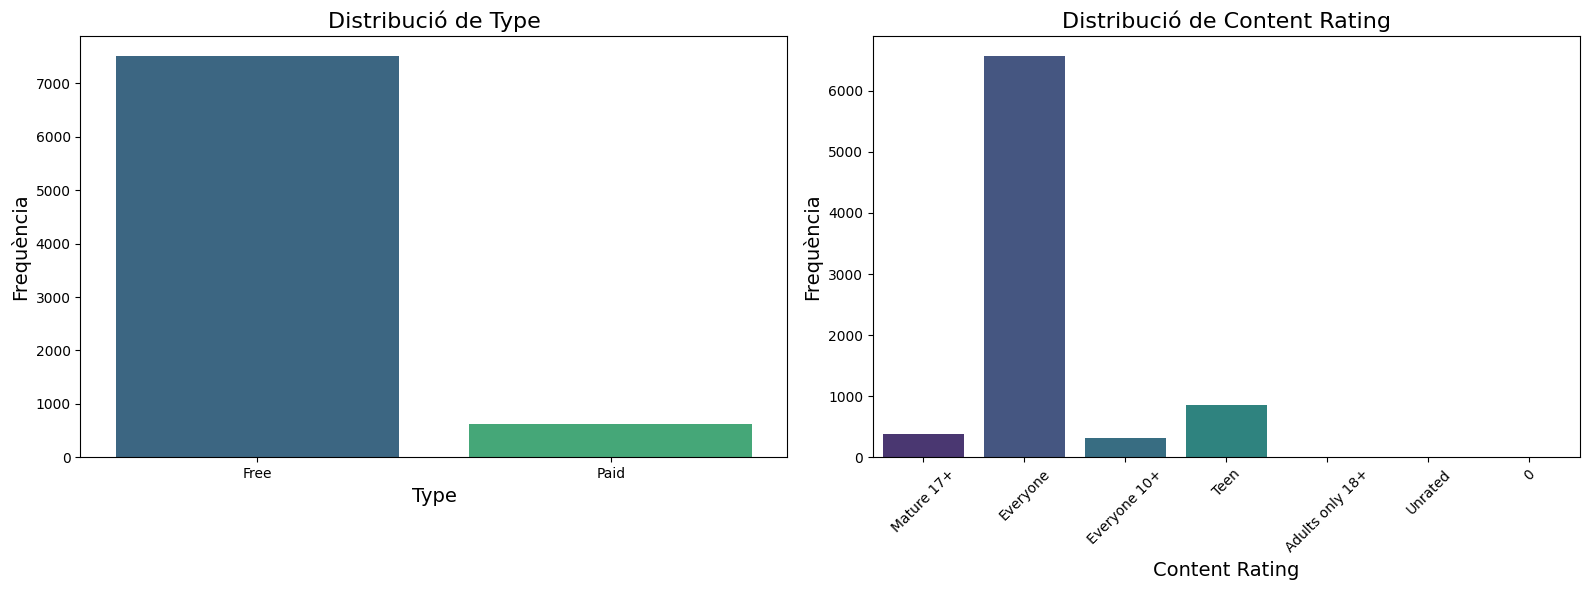

In [656]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gràfica de 'Type'
sns.countplot(data=train_data, x='Type', ax=axes[0], palette="viridis")
axes[0].set_title('Distribució de Type', size=16)
axes[0].set_xlabel('Type', size=14)
axes[0].set_ylabel('Frequència', size=14)

# Gràfica de 'Content Rating'
sns.countplot(data=train_data, x='Content Rating', ax=axes[1], palette="viridis")
axes[1].set_title('Distribució de Content Rating', size=16)
axes[1].set_xlabel('Content Rating', size=14)
axes[1].set_ylabel('Frequència', size=14)
axes[1].tick_params(axis='x', rotation=45)

# Ajustar el layout i mostrar la figura
plt.tight_layout()
plt.show()

Com es pot veure, no s'hi apareix valors anomals en l'atribut *Type*. Podem observar, que hi ha un desbalanceig important, on el valor amb més freqüència és el Free. Pel que fa a l'atribut *Content Rating* ens passa el mateix, no s'hi troben valors anomals, pero hi ha un desbalanceig entre la seva distribució.

- **Genres i Category**: Realitzarem una revisió manual per assegurar-nos que hi hagi valors coherents per cada atribut, al haver excessius per graficar-los.

In [702]:
print("Genres")
print(train_data["Genres"].unique())
print()

print("Category")
print(train_data["Category"].unique())
print()

Genres
['Health & Fitness' 'Photography' 'Entertainment' 'Sports'
 'Travel & Local' 'Lifestyle' 'Shopping' 'Finance'
 'Video Players & Editors' 'Entertainment;Action & Adventure' 'Tools'
 'Role Playing' 'Adventure' 'Education' 'Books & Reference' 'Business'
 'Auto & Vehicles' 'Educational;Education' 'Personalization' 'Racing'
 'Casual' 'Productivity' 'Arcade' 'Communication' 'Food & Drink'
 'Video Players & Editors;Music & Video' 'News & Magazines' 'Puzzle'
 'House & Home' 'Social' 'Board;Brain Games' 'Simulation'
 'Libraries & Demo' 'Action' 'Educational' 'Art & Design' 'Medical'
 'Beauty' 'Events' 'Dating' 'Trivia' 'Simulation;Action & Adventure'
 'Education;Education' 'Strategy' 'Casino' 'Maps & Navigation'
 'Educational;Pretend Play' 'Comics' 'Casual;Pretend Play' 'Weather'
 'Action;Action & Adventure' 'Educational;Brain Games'
 'Entertainment;Brain Games' 'Puzzle;Action & Adventure' 'Music'
 'Education;Brain Games' 'Card' 'Board' 'Sports;Action & Adventure'
 'Racing;Action & Adven

Segons la sortida anterior, podem veure que tenim categories coherents amb la temàtica del dataset, sense trobar ningun valor anòmal.

- **Android Ver**: En aquest cas, veurem la seva distribució i pels valors analitzarem si hi ha algun valor anomal. 

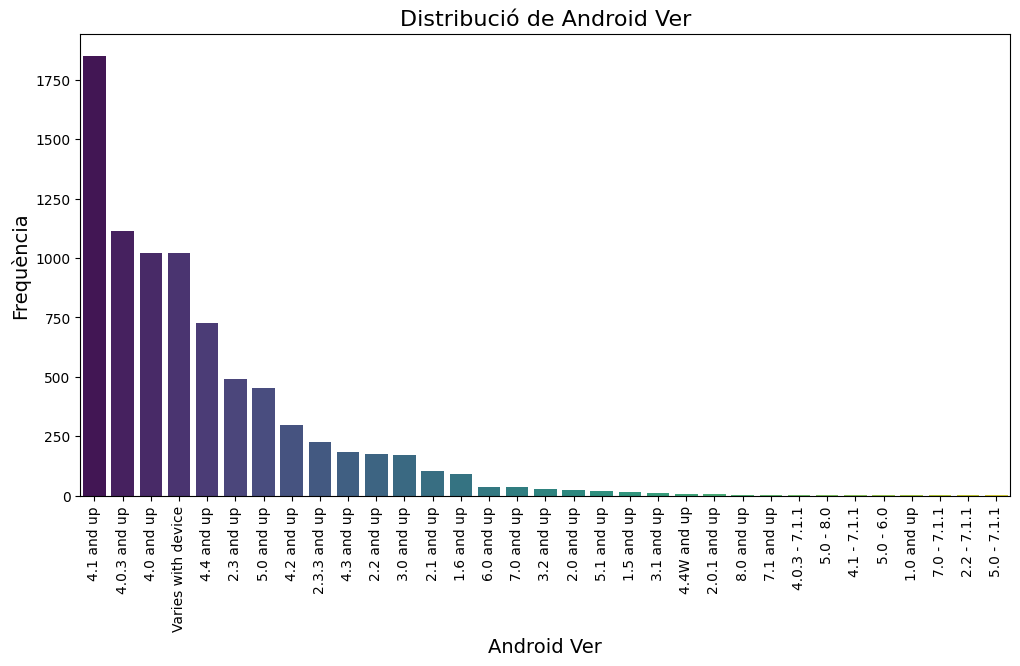

In [658]:
rcParams['figure.figsize'] = 12, 8

plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='Android Ver', palette="viridis", order=train_data['Android Ver'].value_counts().index)
plt.title('Distribució de Android Ver', size=16)
plt.xlabel('Android Ver', size=14)
plt.ylabel('Frequència', size=14)
plt.xticks(rotation=90)  
plt.show()

Com podem veure, la versió "4.1" és la que apareix més sovint. Els valors d'aquest atribut inclouen versions que indiquen una versió mínima seguida de "and up" (com "4.1 and up"), altres que es troben dins d'un interval, i alguns casos on la versió depèn del dispositiu representat amb l'etiqueta *Varies with device*. Aquestes observacions es tindran en compte a l'hora de codificar aquest atribut.

- **Current Ver**: En aquest cas, veurem la seva distribució i pels valors analitzarem si hi ha algun valor anomal. 

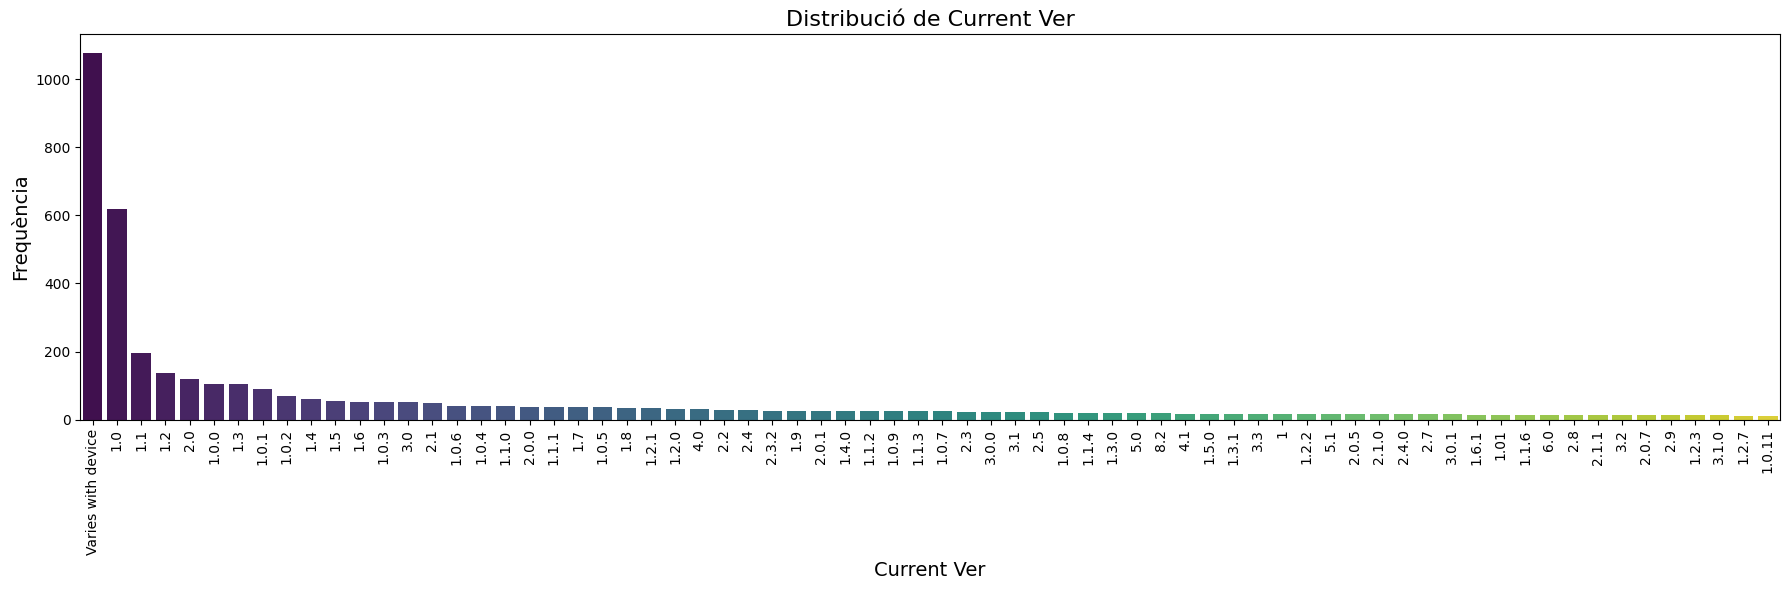

In [659]:
top_values = train_data['Current Ver'].value_counts().head(70).index

plt.figure(figsize=(18, 6))
sns.countplot(data=train_data, x='Current Ver', palette="viridis", order=top_values)
plt.title('Distribució de Current Ver', size=16)
plt.xlabel('Current Ver', size=14)
plt.ylabel('Frequència', size=14)
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

En aquest atribut, hem graficat 70 valors únics per qüestions d'espai. Com en el cas anterior, observem que un dels valors possibles és l'etiqueta *Varies with device*, que en aquest cas és el més freqüent. A més, no s'identifica valors atípics (outliers) en aquesta distribució.

## 2. Preprocessing 

En aquest apartat, es duran a terme tres etapes per preparar els atributs: tractament dels valors nuls, codificació de les variables categòriques i normalització de les columnes. A més, crearem nous atributs amb la intenció de millorar la capacitat del model per identificar patrons 💡. 

### 2.1. Tractament de valors nuls

En aquest apartat, tractarem els valors nuls que ens apareixen en el dataset. Com s'ha vist en la detecció de valors nuls, ens apareixen valors nuls principalment en l'atribut *Rating*, seguidament dels atributs *Current Ver*, *Android Ver* i *Type*. Com a recordatori, a continuació s'imprimeix el nombre de valors nuls dels atributs esmentats:

In [660]:
nan_counts = train_data.isnull().sum()
nan_columns = nan_counts[nan_counts > 0]
sorted_nulls = nan_columns.sort_values(ascending=False)
print(sorted_nulls)

Rating         1095
Current Ver       6
Android Ver       2
Type              1
dtype: int64


Ara tractarem els valors numèrics, en aquest cas l'únic que tenim és l'atribut *Rating*, i a continuació els atributs de tipus categòric. 
Per inserir els valors nuls, podem optar per aplicar la mitjana o la mediana de les dades, depenent de la variànça de les dades. Sabem que, en atributs amb una alta variació, la mitjana no dona un valor representatiu de les dades. Per quantificar aquesta variabilitat, farem servir el coeficient de variació. Si el coeficient és alt, els valors nuls s'inseriran aplicant la mediana. En cas contrari, si el coeficient és baix, els valors nuls s'inseriran aplicant la mitjana. Seguint la convenció, considerarem que un coeficient de variació major al 15% indica que la variació de les dades és alta. 

In [661]:
mean_rating = train_data['Rating'].mean()
std_rating = train_data['Rating'].std()
cv_rating = (std_rating / mean_rating) * 100
print("Coeficient de variació de l'atribut Rating:", cv_rating)

Coeficient de variació de l'atribut Rating: 12.405211627697733


Com que la variança és baixa, emplenarem els valors nuls de l'atribut *Rating* a partir de la mitjana.

In [662]:
# Calcular la mitjana del valor 'Rating' en el conjunt d'entrenament
mean_rating = train_data['Rating'].mean()

# Omplir els valors nuls de 'Rating' amb la mitjana en el conjunt d'entrenament
train_data['Rating'].fillna(mean_rating, inplace=True)

# Omplir els valors nuls de 'Rating' amb la mitjana en el conjunt de test
test_data['Rating'].fillna(mean_rating, inplace=True)

Pels atributs categòrics, els valors nuls els emplenarem amb la categoria més freqüent de la columna, és a dir, utilitzant la moda.

In [663]:
# Omplir els valors nuls a 'Current Ver', 'Android Ver' i 'Type' del conjunt d'entrenament
train_data['Current Ver'] = train_data['Current Ver'].fillna(train_data['Current Ver'].mode()[0])
train_data['Android Ver'] = train_data['Android Ver'].fillna(train_data['Android Ver'].mode()[0])
train_data['Type'] = train_data['Type'].fillna(train_data['Type'].mode()[0])

# Omplir els valors nuls a 'Current Ver', 'Android Ver' i 'Type' del conjunt de prova
test_data['Current Ver'] = test_data['Current Ver'].fillna(train_data['Current Ver'].mode()[0])
test_data['Android Ver'] = test_data['Android Ver'].fillna(train_data['Android Ver'].mode()[0])
test_data['Type'] = test_data['Type'].fillna(train_data['Type'].mode()[0])

### 2.2. Codificació i Normalització d'atributs

Un cop finalitzat el tractament dels valors nuls, aquesta secció se centrarà principalment en la codificació de les variables categòriques, i la creació de nous atributs. Aquest pas és essencial, ja que algorismes com el Support Vector Regression o el regressor lineal, que s'utilitzaran més endavant, requereixen que totes les dades estiguin codificades en format numèric per funcionar correctament.

Com a recordatori, del dataset *train* tenim els següents atributs categòrics: 📋

- **App**  
- **Category**  
- **Reviews** 
- **Size** 
- **Installs** 
- **Type** 
- **Price** 
- **Content Rating** 
- **Genres** 
- **Last Updated** 
- **Current Ver** 
- **Android Ver**

Com a primers atributs, tractarem la columna *Reviews*, *Installs* i *Price*. Com a casos especials, no caldrà codificar aquest atributs. Com s'ha comentat en una secció anterior, son atributs essencialment numèrics, tot i que Pandas els ha assignat com a categòrics. El que farem en aquest cas, pels atributs *Installs* i *Price*, serà eliminar algun caràcter present en els seus valors, i en el tres atributs en conjunt caldrà convertir-los a tipus numèric.

In [664]:
# Atribut Reviews
train_data["Reviews"] = pd.to_numeric(train_data["Reviews"], errors='coerce')
test_data["Reviews"] = pd.to_numeric(test_data["Reviews"], errors='coerce')

# Atribut Installs
# Eliminar '+' i ',' abans de convertir a numèric
installs_cleaned_train = train_data["Installs"].str.replace('+', '', regex=False).str.replace(',', '', regex=False)
train_data["Installs"] = pd.to_numeric(installs_cleaned_train, errors='coerce')

installs_cleaned_test = test_data["Installs"].str.replace('+', '', regex=False).str.replace(',', '', regex=False)
test_data["Installs"] = pd.to_numeric(installs_cleaned_test, errors='coerce')

# Atribut Price
# Eliminar '$' i ',' abans de convertir a numèric
price_cleaned_train = train_data["Price"].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
train_data["Price"] = pd.to_numeric(price_cleaned_train, errors='coerce')
price_cleaned_test = test_data["Price"].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
test_data["Price"] = pd.to_numeric(price_cleaned_test, errors='coerce')


Continuarem codificant els següents atributs categòrics *Genres*, *Category* i *Content Rating*. En aquest cas, utilitzarem el One-Hot Encoding, ja que son atributs que no tenen un ordre en quant el seus valors, la qual cosa fa que altres tècniques com el Label Encoding no siguin apropiades

In [665]:
# Codificació OneHotEncoder per 'Genres'
onehot_encoder = OneHotEncoder(cols=['Genres'], use_cat_names=True)
train_data = onehot_encoder.fit_transform(train_data)
test_data = onehot_encoder.transform(test_data)

# Codificació OneHotEncoder per 'Category'
onehot_encoder = OneHotEncoder(cols=['Category'], use_cat_names=True)
train_data = onehot_encoder.fit_transform(train_data)
test_data = onehot_encoder.transform(test_data)

# Codificació OneHotEncoder per 'Content Rating'
onehot_encoder = OneHotEncoder(cols=['Content Rating'], use_cat_names=True)
train_data = onehot_encoder.fit_transform(train_data)
test_data = onehot_encoder.transform(test_data)

A diferencia dels atributs anteriors, l'atribut *Type* té una relació ordinal, ja que representen categories amb un ordre lògic implícit: Free (gratuït) està en un extrem d'un escala, i Paid (pagat) a l'altre. Per aquesta raó, aplicarem el Label Encoding. 

In [666]:
# Codificació Ordinal per 'Type'
le = OrdinalEncoder()
train_data['Type'] = le.fit_transform(train_data['Type'])
test_data['Type'] = le.transform(test_data['Type'])

En l'atribut *Current Ver*, primer s'ha substituït el valor "Varies with device" per la moda de la columna, ja que aquest valor no aporta informació coherent i la moda és un millor representant de la distribució de les versions. A continuació, s'han eliminat els caràcters no numèrics (com lletres i símbols), conservant només els números i els punts, per assegurar una representació homogènia de les versions. Finalment, s'ha creat una funció per convertir les versions a un format numèric (major.minor.patch), omplint els valors nuls amb la moda calculada prèviament.

In [667]:
# Substituir "Varies with device" per la moda de la columna
mode_current_ver = train_data['Current Ver'].mode()[0]
train_data['Current Ver'] = train_data['Current Ver'].replace('Varies with device', mode_current_ver)

# Eliminar caràcters no numèrics i mantenir només les versions
train_data['Current Ver'] = train_data['Current Ver'].replace(r'[^\d.]', '', regex=True)

# Convertir la versió a un format numèric per simplificar
def versio_a_numero(versio):
    parts = versio.split('.')
    # Normalitzar si falten parts
    while len(parts) < 3:
        parts.append('0')
    return int(''.join(parts[:3]))  # Només agafem les tres primeres parts i les combinem

# Aplicar la conversió a numèric
train_data['Current Ver'] = train_data['Current Ver'].apply(versio_a_numero)

# Omplir valors nuls amb la moda
train_data['Current Ver'].fillna(mode_current_ver, inplace=True)

# Repetir els mateixos passos per al conjunt de test
test_data['Current Ver'] = test_data['Current Ver'].replace('Varies with device', mode_current_ver)
test_data['Current Ver'] = test_data['Current Ver'].replace(r'[^\d.]', '', regex=True)
test_data['Current Ver'] = test_data['Current Ver'].apply(versio_a_numero)
test_data['Current Ver'].fillna(mode_current_ver, inplace=True)

En quant a l'atribut *App*, com que no ens aporta informació, ja que el nom sols ens permet identificar l'aplicació, s'eliminarà del conjunt d'entrenament i del conjunt test.

In [668]:
train_data = train_data.drop('App', axis=1)
test_data = test_data.drop('App', axis=1)

Per a l'atribut *Last Updated*, una manera de convertir-lo en un atribut numèric, seria calcular per a cada element la diferència entre la data més alta del atribut i la data de l'última actualització de l'aplicació. Aquest càlcul ens donarà un valor numèric que representarà el dies transcorreguts des de l'última actualització. Pot ser interessant aquest atribut, ja que comunment les actualitzacions recents de les aplicacions poden ser indicatives de la popularitat d'una aplicació.

In [669]:
# Convertim 'Last Updated' a format datetime en el conjunt d'entrenament
train_data['Last Updated'] = pd.to_datetime(train_data['Last Updated'], format='%B %d, %Y')

# Determinem la data màxima del conjunt d'entrenament
max_train_date = train_data['Last Updated'].max()

# Calculem els dies des de l'última actualització utilitzant la data màxima
train_data['Days Since Last Update'] = (max_train_date - train_data['Last Updated']).dt.days

# Eliminem la columna 'Last Updated' en el conjunt d'entrenament
train_data = train_data.drop(columns=["Last Updated"])

# Repetim les mateixes operacions pel conjunt de prova (test)
test_data['Last Updated'] = pd.to_datetime(test_data['Last Updated'], format='%B %d, %Y')
test_data['Days Since Last Update'] = (max_train_date - test_data['Last Updated']).dt.days
test_data = test_data.drop(columns=["Last Updated"])


En quant a l'atribut *Size*, hem vist que essencialment és numèric, on també i tenim un caràcter que ens indica la unitat de mesura, "M", "k" o "B". En alguns casos, ens apareix que el tamany de l'aplicació depèn del dispositiu, amb l'etiqueta *Varies with device*. El que farem és converir les mides en bytes i elimina seguidament la unitat de mesura, i per aquells valors on es contingui l'etiqueta *Varies with device*, s'emplenarà la mitjana de l'atribut.

In [670]:
# Definir un diccionari de conversió per a les unitats
conversion_factors = {
    'k': 1e3,   # Kilobytes
    'M': 1e6,   # Megabytes
    'B': 1      # Bytes
}

# Funció simplificada per a convertir mides
def convert_size(size):
    size = size.strip()  # Eliminar espais al principi i al final
    if size == "Varies with device":
        return np.nan  # Retornar NaN per ser omplert posteriorment
    else:
        unit = size[-1]
        number = size[:-1]
        
        # Comprovació simple per a assegurar-nos que el número és vàlid
        if number.replace('.', '', 1).isdigit() and unit in conversion_factors:
            number = float(number)
            return number * conversion_factors[unit]  # Multiplicar pel factor corresponent
        else:
            return np.nan  # Si el número no és vàlid, retornar NaN

# Aplicar la funció a les columnes 'Size' en ambdós conjunts de dades
train_data['Size'] = train_data['Size'].apply(convert_size)
test_data['Size'] = test_data['Size'].apply(convert_size)

# Calcular la mitjana de la mida en el conjunt d'entrenament, ignorant els NaN
mean_size = train_data['Size'].mean()

# Omplir els valors perduts amb la mitjana
train_data['Size'].fillna(mean_size, inplace=True)
test_data['Size'].fillna(mean_size, inplace=True)

Per tractar l'atribut *Android Ver*, es farà el següent: quan es trobi el valor "Varies with device", aquest és substituirà per la moda de les versions disponibles per a l'aplicació. Si el valor és del tipus "X and up" (per exemple, "4.0 and up"), s'eliminarà el sufix "and up" i es restarà amb la versió més alta de l'atribut. En cas que es presenti un interval de versions (per exemple, "4.0 - 5.0"), es farà la resta entre la versió mínima i la màxima per obtenir la diferència entre ambdues.
Aquest nou atribut ens pot resultar útil, ja que ens permet quantificar indirectament a quants dispositius podran accedir a l'aplicació. En cas que el valor sigui alt, significarà que molts dispositius tenen compatibilitat amb l'aplicació, i això pot indicar que sigui més descargada.


In [671]:
# Substituir "Varies with device" per la moda de 'Android Ver'
mode_android_ver = train_data['Android Ver'].mode()[0]
train_data['Android Ver'] = train_data['Android Ver'].replace('Varies with device', mode_android_ver)

def normalitzar_versio_android(versio):
    # Tractar els intervals
    if '-' in versio:
        versio_inici, versio_fi = versio.split('-')
        versio_inici = versio_inici.strip()
        versio_fi = versio_fi.strip()
        
        # Assegurar-se que ambdues versions tinguin 3 parts (major.minor.patch)
        parts_inici = versio_inici.split('.')
        parts_fi = versio_fi.split('.')
        
        # Normalitzar amb zeros si falten parts
        versio_inici = '.'.join(parts_inici + ['0'] * (3 - len(parts_inici)))
        versio_fi = '.'.join(parts_fi + ['0'] * (3 - len(parts_fi)))

        # Convertir les versions a números enters (sense punts)
        versio_inici = int(versio_inici.replace('.', ''))
        versio_fi = int(versio_fi.replace('.', ''))

        # Retornar la mitjana de les dues versions
        return (versio_inici + versio_fi) // 2
    
    # Si no és un interval, simplement normalitzar la versió
    parts_versio = versio.split('.')
    if len(parts_versio) < 3:
        versio = '.'.join(parts_versio + ['0'] * (3 - len(parts_versio)))
    return versio.replace('.', '')  # Retornar sense punts per convertir en enter

# Normalitzar i convertir les versions en el conjunt d'entrenament
train_data['Android Ver'] = train_data['Android Ver'].apply(normalitzar_versio_android)

# Convertir a numèric (coerció de valors no vàlids a NaN)
train_data['Android Ver'] = pd.to_numeric(train_data['Android Ver'], errors='coerce')

# Restar la versió màxima
max_version = train_data['Android Ver'].max()
train_data['Android Ver'] = max_version - train_data['Android Ver']

# Repetir operacions per al conjunt de test
test_data['Android Ver'] = test_data['Android Ver'].replace('Varies with device', mode_android_ver)
test_data['Android Ver'] = test_data['Android Ver'].apply(normalitzar_versio_android)

# Convertir a numèric (coerció de valors no vàlids a NaN)
test_data['Android Ver'] = pd.to_numeric(test_data['Android Ver'], errors='coerce')

# Restar la versió màxima del conjunt de test
test_data['Android Ver'] = max_version - test_data['Android Ver']

# Omplir NaN amb la mitjana (o altre valor)
mean_version = train_data['Android Ver'].mean()
train_data['Android Ver'].fillna(mean_version, inplace=True)
test_data['Android Ver'].fillna(mean_version, inplace=True)


Ja acabada la codificació dels atributs, per garantir un millor rendiment dels models que entrenarem, el que farem és normalitzar les dades, ja que algunes variables tenen rangs diferents, com l'atribut *Last Updated*, *Size*, *Android Ver*, etc. Per aquesta raó, utilitzarem la normalització MinMaxScaler, que ajusta les dades a un rang entre 0 i 1. 

In [672]:
scaler = MinMaxScaler()

data_escalada_train = scaler.fit_transform(train_data)
train_data = pd.DataFrame(data_escalada_train, columns=train_data.columns)

data_escalada_test = scaler.transform(test_data)
test_data = pd.DataFrame(data_escalada_test, columns=test_data.columns)

Al final, el nombre d'atributs que ens ha quedat en aquesta etapa és el següent:

In [673]:
print(f"Nombre d'atributs al dataset: {len(train_data.columns)}")

Nombre d'atributs al dataset: 160


Podem veure que el nombre és força alt, i això ens pot dificultar a la hora de fer la cerca dels millors hiperparàmetres. En el següent apartat s'intentarà reduïr el nombre d'atributs.

### 2.3. Selecció d'atributs

Una vegada hem codificat i normalitzat els atributs, el següent pas serà eliminar aquells que no tinguin una bona correlació amb l'objectiu principal. En concret, descartarem els atributs amb una correlació inferior al 5%. Això ens ajudarà a reduir el nombre d'atributs, mantenint els atributs rellevants, fent més fàcil i ràpid l'entrenament de diversos models i la cerca profunda dels millors hiperparàmetres. 

Per iniciar, ens centrarem primer en l'anàlisis d'atributs que no han estat codificats pel One-HotEncoding. A continuació es visualitzarà les correlacions amb el target *Installs* que passen el llindar mínim dels atributs següents: *Installs*, *Reviews*, *Rating*, *Price*, *Type*, *Size*, *Days Since Last Update*, *Android Ver* i *Current Ver*.

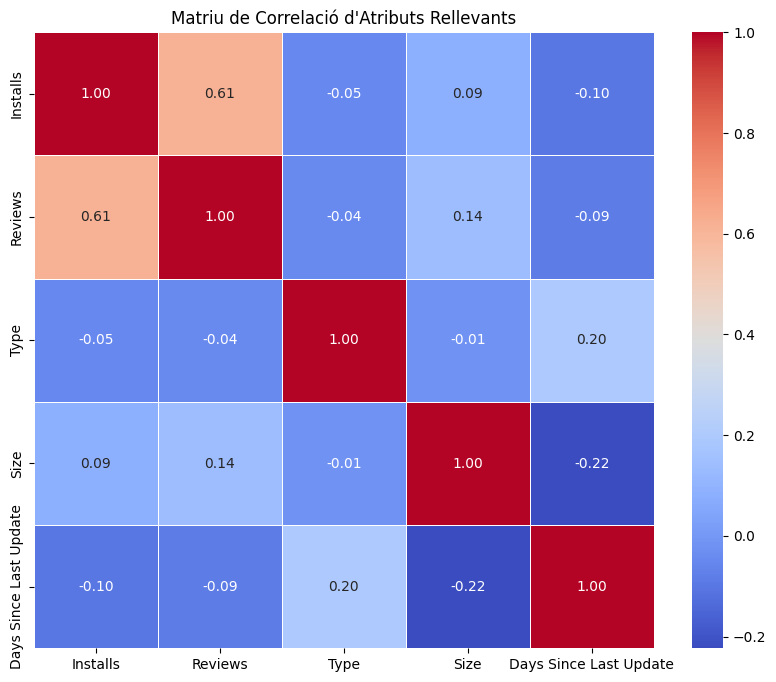

In [674]:
# Selecció d'atributs i càlcul de la matriu de correlació
atributs = ['Installs', 'Reviews', 'Rating', 'Price', 'Type', 'Size', 'Days Since Last Update', 'Android Ver', 'Current Ver']
X_train_encoded = train_data[atributs]
matriu_correlacio = X_train_encoded.corr()
corr_installs = matriu_correlacio['Installs'].abs()
atributs_rellevants = corr_installs[corr_installs >= 0.05].index.tolist()

# Filtrat i visualització
X_train_filtrat = X_train_encoded[atributs_rellevants]
matriu_correlacio_filtrada = X_train_filtrat.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriu_correlacio_filtrada, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriu de Correlació d\'Atributs Rellevants')
plt.show()

En la figura anterior, es pot destacar l'atribut *Reviews*, que presenta una correlació significativa del 61% amb *Installs*. Per contra, alguns atributs com *Current Ver*, *Android Ver* i *Price* no ens apareixen, indicant que no han aconseguit arribar al llindar mínim de correlació establert. A continuació, procedirem a eliminar aquests atributs del dataset, ja que no estan suficientment correlacionats amb l'objectiu principal. 

In [675]:
# Eliminar Android Ver i Current Ver del train_data
train_data.drop(['Android Ver', 'Current Ver', 'Price'], axis=1, inplace=True)

# Eliminar Android Ver i Current Ver del train_set
test_data.drop(['Android Ver', 'Current Ver', 'Price'], axis=1, inplace=True)

En aquest apartat, ens centrarem en els atributs codificats mitjançant One-Hot Encoding: *Content Rating*, *Genres* i *Category*. D'aquests, representarem gràficament només aquells que compleixin la correlació mínima requerida amb el target.

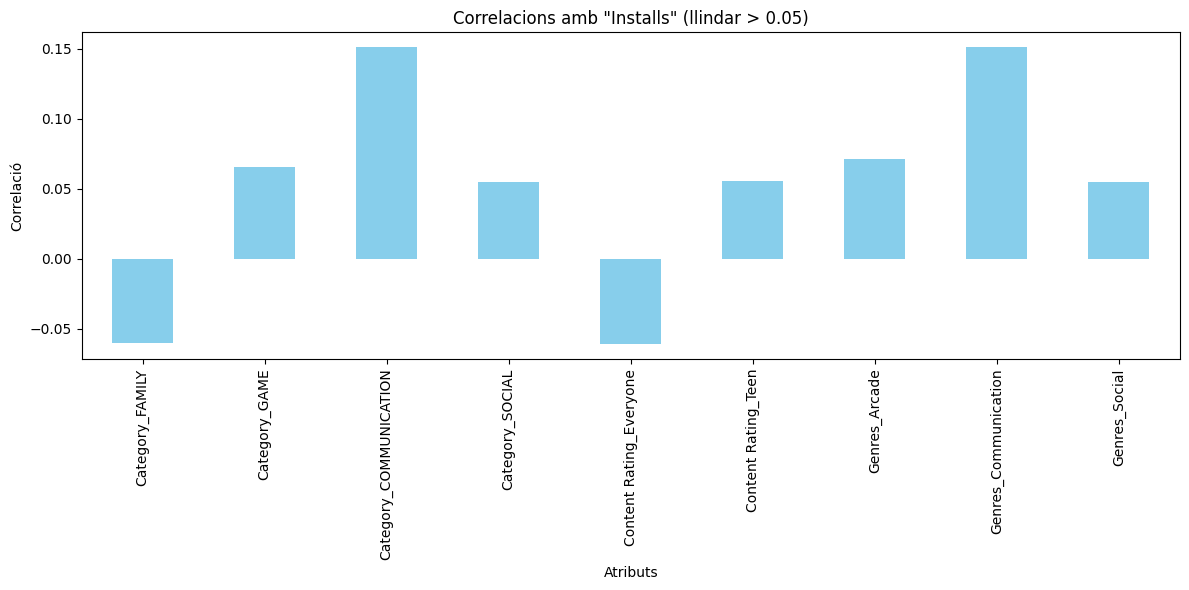

In [676]:
# Definir el llindar i seleccionar les columnes potencials
threshold = 0.05
potential_columns = [col for col in train_data.columns if col.startswith('Content') 
                     or col.startswith('Category') 
                     or col.startswith('Genre')] + ['Installs']

# Calcular la matriu de correlació i filtrar pel llindar
correlation_installs = train_data[potential_columns].corr()['Installs']
columns_above_threshold = correlation_installs[correlation_installs.abs() > threshold].index.tolist()

# Identificar columnes que no compleixen amb el llindar
columns_below_threshold = [col for col in potential_columns if col not in columns_above_threshold and col != 'Installs']

# Visualitzar les correlacions que compleixen amb el llindar
correlation_passing = correlation_installs[correlation_installs.abs() > threshold].drop('Installs', errors='ignore')
correlation_passing.plot(kind='bar', figsize=(12, 6), color='skyblue', 
                         title=f'Correlacions amb "Installs" (llindar > {threshold})')
plt.ylabel('Correlació')
plt.xlabel('Atributs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

A partir de la figura anterior, podem veure que molts dels atributs que teníem inicialment no han sobrepassat el llindar. Dels que podem visualitzar, destaquem l'atribut *Category_COMMUNICATION* i el *Genres_COMMUNICATION*, obtenint una correlació de Pearson propera el 15%. D'aquells que no han sobrepassat el llindar, a continuació s'eliminaran del conjunt d'entrenament i el de prova.

In [677]:
# Eliminar columnes que no compleixen el llindar de train_data i test_data
train_data.drop(columns=columns_below_threshold, inplace=True, errors='ignore')
test_data.drop(columns=columns_below_threshold, inplace=True, errors='ignore')

Ja acabats, visualitzarem els atributs finals que ens permetran entrenar els models:

In [678]:
print(f"NOMBRE D'ATRIBUTS: {train_data.shape[1]}")
print(train_data.dtypes)

NOMBRE D'ATRIBUTS: 15
Category_FAMILY            float64
Category_GAME              float64
Category_COMMUNICATION     float64
Category_SOCIAL            float64
Rating                     float64
Reviews                    float64
Size                       float64
Installs                   float64
Type                       float64
Content Rating_Everyone    float64
Content Rating_Teen        float64
Genres_Arcade              float64
Genres_Communication       float64
Genres_Social              float64
Days Since Last Update     float64
dtype: object


Com podem veure, ha hagut una millora important en la reducció dels atributs. Dels 160 atributs que teníem el codificar les columnes, ens hem quedat amb els més rellevants, concretament 15.

## 3. Entrenament i Selecció del model òptim

En aquest apartat, treballarem amb diferents models de regressió, aplicant tècniques d'aprenentatge supervisat. Utilitzarem el coeficient de determinació R² com a mètrica principal per avaluar el rendiment dels models. Aquesta mètrica mesura la proporció de la variabilitat dels valors objectiu que pot ser explicada pel model. Valors més alts de R² indiquen que el model explica millor les dades i, per tant, ofereix millors resultats.

Per valorar els models de manera equilibrada, farem servir K-Fold Cross Validation. Aquest mètode assegura que totes les dades s’utilitzin tant per entrenar com per testejar, repartint-les en diferents combinacions. Això ens donarà una visió més completa de com es comporta cada model.

A més, generarem i analitzarem corbes d'aprenentatge per comprendre com els models responen a diferents volums de dades d'entrenament. Aquestes corbes ens ajudaran a identificar problemes com el sobreajustament (quan el model s'adapta massa a les dades d'entrenament però no generalitza bé) o el subajustament (quan el model no aprèn prou dels patrons de les dades). Aquesta anàlisi permetrà ajustar els models per millorar la seva eficiència.

Pel que fa als models, provarem els següents: Regressió Lineal, SVR (Support Vector Regressor), KNeighbors Regressor, Decision Tree Regressor i Random Forest Regressor. Aquests enfoquem van des de tècniques lineals fins a mètodes basats en arbres i veïns propers, cosa que ens permetrà triar el que millor s'adapti a les nostres dades.

Aquesta secció es dividirà en tres parts:

- **Entrenament amb Paràmetres per Defecte:** Inicialment, entrenarem tots els models utilitzant els seus paràmetres predeterminats per establir una línia base del rendiment.

- **Entrenament amb Hiperparàmetres Òptims:** En aquesta segona fase, realitzarem una cerca amb GridSearchCV per identificar els millors hiperparàmetres, i entrenarem els models amb aquests paràmetres òptims per maximitzar el seu rendiment.

- **Anàlisi de Corbes d'Aprenentatge:** Finalment, generarem i analitzarem les corbes d'aprenentatge per avaluar la capacitat dels models d'ajustar-se a les dades i detectar problemes com el sobreajustament o el subajustament.

- **Selecció del model òptim:** Seleccionarem el model que ens dona millors resultats, tenint en compte els apartats anteriors.

### 3.1. Entrenament amb Paràmetres per Defecte

Com a primer pas, separarem l'atribut target del conjunt train:

In [679]:
X = train_data.drop('Installs', axis=1)
y = train_data['Installs']

A continuació, entrenarem els models esmentats utilitzant els seus paràmetres per defecte, i aplicant el K-Fold cross-validation per assegurar una avaluació equilibrada. Com a resultat, obtindrem el valor mitjà de la mètrica R² per a cada model.

In [680]:
# Definir la métrica R² i el KFold amb 5 particions
scorer = make_scorer(r2_score)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# CROSS-VALIDATION DE LINEAR REGRESSION
model = LinearRegression()
lr_scores = cross_val_score(model, X, y, n_jobs=-1, cv=kfold, scoring=scorer)
print("LinearRegression:")
print(f"Scores en cada fold: {lr_scores}")
print(f"Mitjana del score R²: {round(lr_scores.mean(), 5)}")

# CROSS-VALIDATION DE SVR
model = SVR()
svr_scores = cross_val_score(model, X, y, n_jobs=-1, cv=kfold, scoring=scorer)
print("\nSVR:")
print(f"Scores en cada fold: {svr_scores}")
print(f"Mitjana del score R²: {round(svr_scores.mean(), 5)}")

# CROSS-VALIDATION DE KNeighborsRegressor
model = KNeighborsRegressor()
knr_scores = cross_val_score(model, X, y, n_jobs=-1, cv=kfold, scoring=scorer)
print("\nKNeighborsRegressor:")
print(f"Scores en cada fold: {knr_scores}")
print(f"Mitjana del score R²: {round(knr_scores.mean(), 5)}")

# CROSS-VALIDATION DE DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=0)
dtr_scores = cross_val_score(model, X, y, n_jobs=-1, cv=kfold, scoring=scorer)
print("\nDecisionTreeRegressor:")
print(f"Scores en cada fold: {dtr_scores}")
print(f"Mitjana del score R²: {round(dtr_scores.mean(), 5)}")

# CROSS-VALIDATION DE RandomForestRegressor
model = RandomForestRegressor(random_state=0)
rfr_scores = cross_val_score(model, X, y, n_jobs=-1, cv=kfold, scoring=scorer)
print("\nRandomForestRegressor:")
print(f"Scores en cada fold: {rfr_scores}")
print(f"Mitjana del score R²: {round(rfr_scores.mean(), 5)}")


LinearRegression:
Scores en cada fold: [0.39454553 0.47368386 0.22250236 0.38152467 0.44590805]
Mitjana del score R²: 0.38363

SVR:
Scores en cada fold: [-0.26950767 -0.26838905 -0.59297968 -0.75445318 -0.31830582]
Mitjana del score R²: -0.44073

KNeighborsRegressor:
Scores en cada fold: [0.48943931 0.61175552 0.52818463 0.58382291 0.72003357]
Mitjana del score R²: 0.58665

DecisionTreeRegressor:
Scores en cada fold: [0.69132563 0.80495961 0.6874773  0.88560651 0.76339159]
Mitjana del score R²: 0.76655

RandomForestRegressor:
Scores en cada fold: [0.78880752 0.83985419 0.87330808 0.88252016 0.79402245]
Mitjana del score R²: 0.8357


A continuació, analitzarem i representarem gràficament la mitjana del coeficient de determinació R² per a cada model: 📊

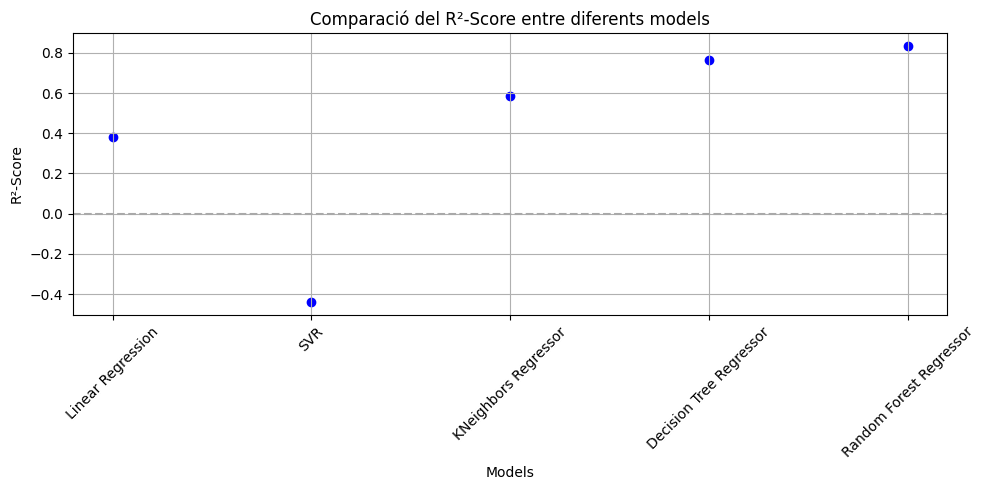

In [681]:
models = ['Linear Regression', 'SVR', 'KNeighbors Regressor', 'Decision Tree Regressor', 'Random Forest Regressor']
r2_means = [lr_scores.mean(), svr_scores.mean(), knr_scores.mean(), dtr_scores.mean(), rfr_scores.mean()]

plt.figure(figsize=(10, 5))
plt.scatter(models, r2_means, color='blue')  
plt.axhline(0, color='darkgray', linestyle='--', linewidth=1.5)  

plt.xlabel('Models')
plt.ylabel('R²-Score')
plt.title('Comparació del R²-Score entre diferents models')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El gràfic mostra que el *Random Forest Regressor* és el model que millor funciona, amb un coeficient de determinació del 0.82 aproximadament. Això indica que el model entén bé la relació entre les variables d'entrada i el resultat, i és capaç de predir-lo amb precisió. També destaca el *Decision Tree Regressor*, que ofereix un bon comportament. En canvi, l'algoritme amb els resultats més deficients és el *SVR*, amb un coeficient de determinació negatiu, fet que evidencia que no fa bones prediccions. Així, el *Random Forest Regressor* es presenta com la millor opció per aquest cas.

### 3.2. Entrenament amb Hiperparàmetres Òptims

Amb l'objectiu de treure el màxim profit de cada model, continuarem el nostre treball cercant els millors hiperparàmetres de cada model, amb l'objectiu de maximitzar el coeficient de determinació. En aquest cas, s'ha utilitzat el Grid Search, ja que el nombre d'atributs a provar no és elevat, i per tant el cost computacional tampoc ho és. Així, podem explorar exhaustivament totes les combinacions possibles i optimitzar els resultats.

A continuació, es presenten els hiperparàmetres que es provaran per a cada model:

- **Linear Regression**
  - **fit_intercept**: Controla si el model inclourà una constant en la regressió. Quan es desactiva, es força la regressió a passar per l'origen.

- **SVR (Support Vector Regressor)**
  - **C**: Controla la penalització per errors a la funció de cost. Valors grans permeten ajustar millor les dades (risc de sobreajustament), mentre que valors petits fomenten models més simples.
  - **kernel**: Funció nucli utilitzada (p.ex. 'linear', 'rbf').
  - **gamma**: Determina la influència de cada mostra. Valors alts focalitzen l’atenció en punts més propers; valors baixos amplien la influència.

- **KNeighbors Regressor**
  - **n_neighbors**: Nombre de veïns considerats per fer la predicció.
  - **weights**: Ponderació dels veïns ('uniform' o 'distance').
  - **metric**: Mètrica utilitzada per calcular la distància (p.ex. 'euclidean', 'manhattan').

- **Decision Tree Regressor**
  - **max_depth**: Profunditat màxima de l'arbre. Un valor gran pot afavorir el sobreajustament, mentre que un valor massa petit pot dificultar capturar la complexitat de les dades.
  - **criterion**: Funció per mesurar la qualitat d’una divisió (p.ex. 'squared_error', 'absolute_error').

- **Random Forest Regressor**
  - **n_estimators**: Nombre d'arbres del bosc. Més arbres milloren poden millorar la precisió.
  - **max_depth**: Límit de profunditat dels arbres individuals.

In [682]:
# Definir la métrica R² i el KFold amb 5 particions
scorer = make_scorer(r2_score)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Funció per calcular la mitjana del R²
def calcular_mitjana_r2(grid_search, X, y):
    scores = cross_val_score(grid_search.best_estimator_, X, y, cv=kfold, scoring='r2')
    return scores.mean()

# GRID SEARCH DE LINEAR REGRESSION
param_grid = {
    'fit_intercept': [True, False]
}
lr_model = LinearRegression()
grid_lr = GridSearchCV(lr_model, param_grid, cv=kfold, scoring=scorer, n_jobs=-1)
grid_lr.fit(X, y)
lr_mean_score = calcular_mitjana_r2(grid_lr, X, y)
print("Grid Search de Linear Regression:")
print(f"Millors paràmetres: {grid_lr.best_params_}")
print(f"Mitjana del R²: {round(lr_mean_score, 5)}")

# GRID SEARCH DE SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svr_model = SVR()
grid_svr = GridSearchCV(svr_model, param_grid, cv=kfold, scoring=scorer, n_jobs=-1)
grid_svr.fit(X, y)
svr_mean_score = calcular_mitjana_r2(grid_svr, X, y)
print("\nGrid Search de SVR:")
print(f"Millors paràmetres: {grid_svr.best_params_}")
print(f"Mitjana del R²: {round(svr_mean_score, 5)}")

# GRID SEARCH DE KNeighborsRegressor
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knr_model = KNeighborsRegressor()
grid_knr = GridSearchCV(knr_model, param_grid, cv=kfold, scoring=scorer, n_jobs=-1)
grid_knr.fit(X, y)
knr_mean_score = calcular_mitjana_r2(grid_knr, X, y)
print("\nGrid Search de KNeighborsRegressor:")
print(f"Millors paràmetres: {grid_knr.best_params_}")
print(f"Mitjana del R²: {round(knr_mean_score, 5)}")

# GRID SEARCH DE DecisionTreeRegressor
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'criterion': ['squared_error', 'absolute_error']
}
dtr_model = DecisionTreeRegressor(random_state=0)
grid_dtr = GridSearchCV(dtr_model, param_grid, cv=kfold, scoring=scorer, n_jobs=-1)
grid_dtr.fit(X, y)
dtr_mean_score = calcular_mitjana_r2(grid_dtr, X, y)
print("\nGrid Search de DecisionTreeRegressor:")
print(f"Millors paràmetres: {grid_dtr.best_params_}")
print(f"Mitjana del R²: {round(dtr_mean_score, 5)}")

# GRID SEARCH DE RandomForestRegressor
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10]
}
rfr_model = RandomForestRegressor(random_state=0)
grid_rfr = GridSearchCV(rfr_model, param_grid, cv=kfold, scoring=scorer, n_jobs=-1)
grid_rfr.fit(X, y)
rfr_mean_score = calcular_mitjana_r2(grid_rfr, X, y)
print("\nGrid Search de RandomForestRegressor:")
print(f"Millors paràmetres: {grid_rfr.best_params_}")
print(f"Mitjana del R²: {round(rfr_mean_score, 5)}")


Grid Search de Linear Regression:
Millors paràmetres: {'fit_intercept': True}
Mitjana del R²: 0.38363

Grid Search de SVR:
Millors paràmetres: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mitjana del R²: 0.11228

Grid Search de KNeighborsRegressor:
Millors paràmetres: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Mitjana del R²: 0.83009

Grid Search de DecisionTreeRegressor:
Millors paràmetres: {'criterion': 'squared_error', 'max_depth': 10}
Mitjana del R²: 0.79006

Grid Search de RandomForestRegressor:
Millors paràmetres: {'max_depth': 10, 'n_estimators': 200}
Mitjana del R²: 0.83418


A continuació, analitzarem i representarem gràficament la mitjana del coeficient de determinació R² per a cada model, havent escollit els millors hiperparàmetres: 📊

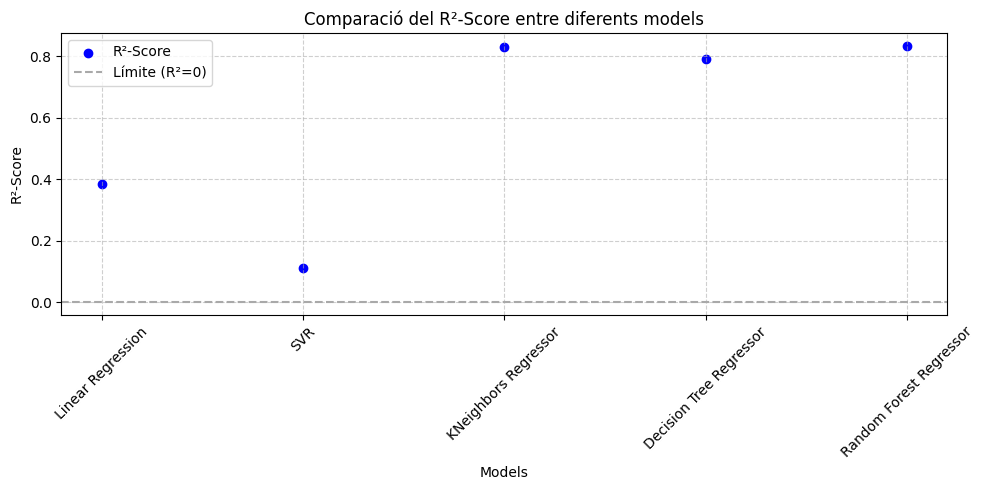

In [683]:
models = ['Linear Regression', 'SVR', 'KNeighbors Regressor', 'Decision Tree Regressor', 'Random Forest Regressor']
r2_means = [lr_mean_score, svr_mean_score, knr_mean_score, dtr_mean_score, rfr_mean_score]

plt.figure(figsize=(10, 5))
plt.scatter(models, r2_means, color='blue', label='R²-Score')  
plt.axhline(0, color='darkgray', linestyle='--', linewidth=1.5, label='Límite (R²=0)')  

# Etiquetas y formato
plt.xlabel('Models')
plt.ylabel('R²-Score')
plt.title('Comparació del R²-Score entre diferents models')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Com podem veure, respecte la gràfica anterior, veiem un canvi important en els models *KNeighbors Regressor* i *SVR*. Pels atributs restants, el canvi no és significatiu, tot i que el *Random Forest Regressor* es manté com el millor model.

### 3.3. Anàlisi de les Corbes d'aprenentatge

Per tal de entrar en detall amb el comportament dels models, utilitzarem la corba d'aprenentatge. Aquesta gràfica ens mostrarà com es el rendiment de cada model entrenat amb els millors hiperparàmetres trobats anteriorment a mesura que s'incrementa la quantitat de dades que s'utilitza a l'entrenament. S'utilitzarà aquestes corbes per identificar quin model generalitza millor les dades de validació respecte als altres models utilitzant el coeficient de determinació com a mètrica. A continuació, analitzarem els resultats amb detall.

In [684]:
def evaluate_learning_curve(models, model_names, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  

    for idx, model in enumerate(models):
        name = model_names[idx]
        print(f"\nModel: {name}")
        
        N, train_lc, val_lc = learning_curve(
            model, X, y, cv=kfold,
            train_sizes=np.linspace(0.05, 1, 25),  
            n_jobs=-1,
            scoring='r2'  
        )
        
        mean_train_score = np.mean(train_lc, axis=1)
        mean_val_score = np.mean(val_lc, axis=1)
        
        final_train_score = mean_train_score[-1]
        final_val_score = mean_val_score[-1]
        difference_final = final_train_score - final_val_score
        
        validation_score = final_val_score
        
        print(f"Diferència final entre entrenament i validació: {difference_final:.4f}")
        print(f"Puntuació final de validació: {validation_score:.4f}")

models = [
    grid_lr.best_estimator_,
    grid_svr.best_estimator_,
    grid_knr.best_estimator_,
    grid_dtr.best_estimator_,
    grid_rfr.best_estimator_
]
model_names = ["Linear Regression", "SVR", "KNeighbors Regressor", "Decision Tree Regressor", "Random Forest Regressor"]
evaluate_learning_curve(models, model_names, X, y)


Model: Linear Regression
Diferència final entre entrenament i validació: 0.0064
Puntuació final de validació: 0.3860

Model: SVR
Diferència final entre entrenament i validació: 0.0489
Puntuació final de validació: 0.1037

Model: KNeighbors Regressor
Diferència final entre entrenament i validació: 0.1781
Puntuació final de validació: 0.8219

Model: Decision Tree Regressor
Diferència final entre entrenament i validació: 0.1826
Puntuació final de validació: 0.8103

Model: Random Forest Regressor
Diferència final entre entrenament i validació: 0.1315
Puntuació final de validació: 0.8383


En quant el menor sobreajustament, tenim el model *Linear Regressor*, que presenta una diferència molt baixa entre entrenament i validació, el que significa que no sobreajusta gaire, però el seu rendiment final és limitat amb una puntuació final de validació del 0.386. Seguidament, tenim el model *SVR* que té una diferència final no molt elevada, però la seva puntuació de validació és força baixa, concretament del 0.010. Pels models restants, *KNN*, *Random Forest* i *Decision Tree*, presenten diferències més grans entre entrenament i validació, indicant un possible sobreajustament. 

Per veure-ho més clar, a continuació es graficarà les corbes d'aprenentatge dels models:

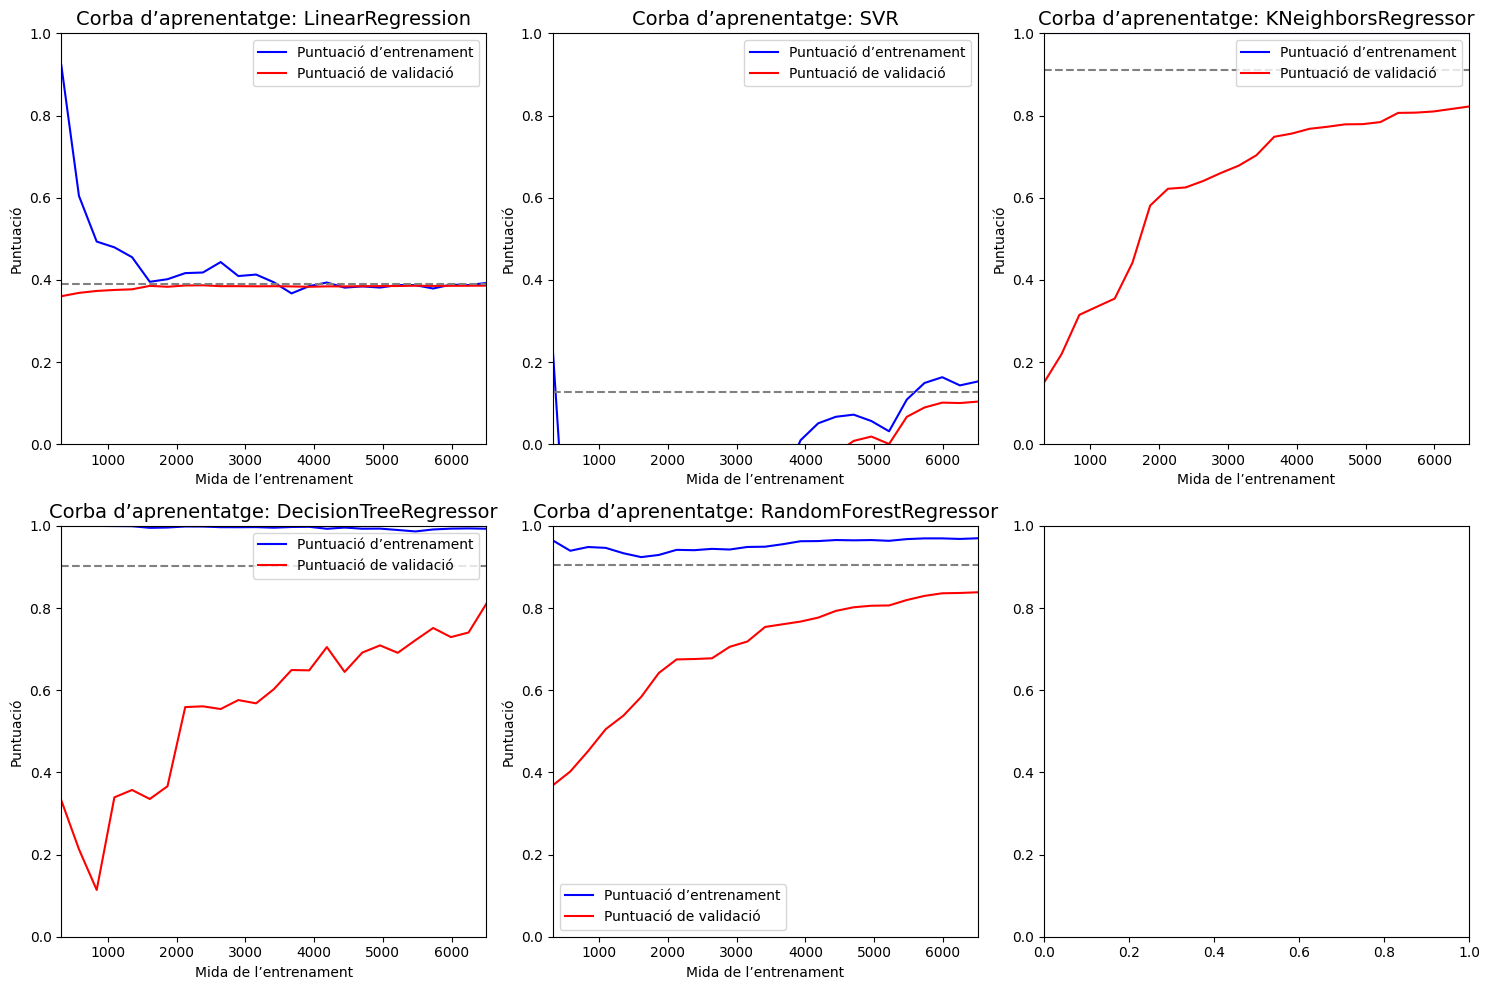

In [685]:
def plot_learning_curves(models, X, y):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.ravel()  
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for i, model in enumerate(models):
        N, train_lc, val_lc = learning_curve(
            model, X, y, cv=kfold,
            train_sizes=np.linspace(0.05, 1, 25),  
            n_jobs=-1,
            scoring='r2'
        )
    
        axs[i].plot(N, np.mean(train_lc, axis=1), color='blue', label='Puntuació d’entrenament')
        axs[i].plot(N, np.mean(val_lc, axis=1), color='red', label='Puntuació de validació')
        axs[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')
        
        axs[i].set_ylim(0, 1)
        axs[i].set_xlim(N[0], N[-1])
        axs[i].set_xlabel('Mida de l’entrenament')
        axs[i].set_ylabel('Puntuació')
        axs[i].set_title(f'Corba d’aprenentatge: {model.__class__.__name__}', size=14)
        axs[i].legend(loc='best')

    plt.tight_layout()  
    plt.show()

# Llista de models a graficar
model_names = ["Linear Regression", "SVR", "KNeighbors Regressor", "Decision Tree Regressor", "Random Forest Regressor"]
plot_learning_curves(models, X, y)

### 3.4. Selecció del model òptim

Per a prendre la decisió final del millor model, el que farem és predir l'atribut target a partir dels millors hiperparàmetres que s’han trobat en la validació, utilitzant un conjunt de dades no vist anteriorment. En aquest secció, seguirem utilitzant la mètrica 
R², ja que ens permet una millor interpretació del rendiment:

In [686]:
# Preparació de les dades
X_train = train_data.drop(columns=['Installs'])
y_train = train_data['Installs']
X_test = test_data.drop(columns=['Installs'])
y_test = test_data['Installs']

# Models i els seus millors hiperparàmetres
models = {
    "Linear Regression": LinearRegression(fit_intercept=False),
    "SVR": SVR(C=100, gamma='scale', kernel='rbf'),
    "KNeighbors Regressor": KNeighborsRegressor(
        metric='manhattan', n_neighbors=11, weights='distance'
    ),
    "Decision Tree Regressor": DecisionTreeRegressor(
        criterion='squared_error', max_depth=10
    ),
    "Random Forest Regressor": RandomForestRegressor(
        max_depth=10, n_estimators=50
    )
}

# Entrenament i avaluació del model
results = {"Model": [], "R² al test": []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred_test)
    results["Model"].append(model_name)
    results["R² al test"].append(test_r2)

results_df = pd.DataFrame(results)
print(results_df)

                     Model  R² al test
0        Linear Regression    0.539192
1                      SVR    0.233484
2     KNeighbors Regressor    0.838095
3  Decision Tree Regressor    0.708220
4  Random Forest Regressor    0.864150


Com podem veure, a l'hora de veure el rendiment que tenen els models el predir dades no vistes, el *Random Forest Regressor* és qui ens ofereix el millor rendiment, amb un coeficient de determinació del 0.86.

Com a conclusió, el *Random Forest Regressor* és el “millor” model en el sentit de millor compromís entre rendiment predictiu i estabilitat. És cert que el *Decision Tree Regressor* presenta una puntuació bona a l'hora de predir dades no vistes, però com s'ha vist en les corbes d'aprenentatge, té una puntuació de validació mitjana més baixa, fet que indica un risc més elevat de sobreajustament.

## 5. Annexes

En aquest apartat es treballa amb el dataset *reviews*, un conjunt de dades que no s'ha utilitzat per entrenar el model *òptim*, ja que només cobreix el 10% de les aplicacions presents en el dataset *apps*. Tot i així, en aquest secció es realitza una anàlisi exploratòria d'aquest conjunt de dades. En aquesta anàlisi es descriuen els seus atributs, es detecten valors nuls i anòmals, i es calcula la correlació de les seves columnes amb el target, l'atribut Installs.

### 5.1. Descripció dels atributs

In [687]:
apps_data = pd.read_csv("data/aplicacions.csv")
reviews_data = pd.read_csv("data/ressenyes.csv")
reviews_data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [688]:
print("El nombre de mostres que tenim a la base de dades és de", reviews_data.shape[0])
print("El nombre d'atributs que tenim a la base de dades és de", reviews_data.shape[1])

El nombre de mostres que tenim a la base de dades és de 64295
El nombre d'atributs que tenim a la base de dades és de 5


Es pot veure que disposem de 5 atributs diferents amb un total de 64295 mostres. A continuació, descriurem els atributs.

In [689]:
print("Informació de cada atribut:")
print(reviews_data.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB
None


El conjunt de dades conté 5 atributs on es descriu les característiques de reviews de cada aplicació. A continuació es fa una breu descripció de cada *feature*:

- **App (Objecte):** Nom de l'aplicació a la qual pertany la ressenya. Ens serveix com enllaç del dataset anterior. 
- **Translated_Review (Objecte):** Comentari de l'usuari de l'aplicació traduït a l'anglès. Pot contenir valors nuls si no hi ha comentari. 
- **Sentiment (Objecte):** Categoria del sentiment expressat en el comentari de l'usuari (per exemple, "Positiu", "Negatiu" o "Neutral").  
- **Sentiment_Polarity (Float64):** Mesura de polaritat del sentiment del comentari de l'usuari, amb valors entre -1 (molt negatiu) i 1 (molt positiu).  
- **Sentiment_Subjectivity (Float64):** Mesura de subjectivitat del comentari de l'usuari, amb valors entre 0 (totalment objectiu) i 1 (totalment subjectiu). 

### 5.2. Detecció de valors nuls

Segons la sortida anterior podem veura una gran quantitat de valors nuls en les característiques, excepte l'atribut *App*. Anem a veure la distribució per cada atribut:

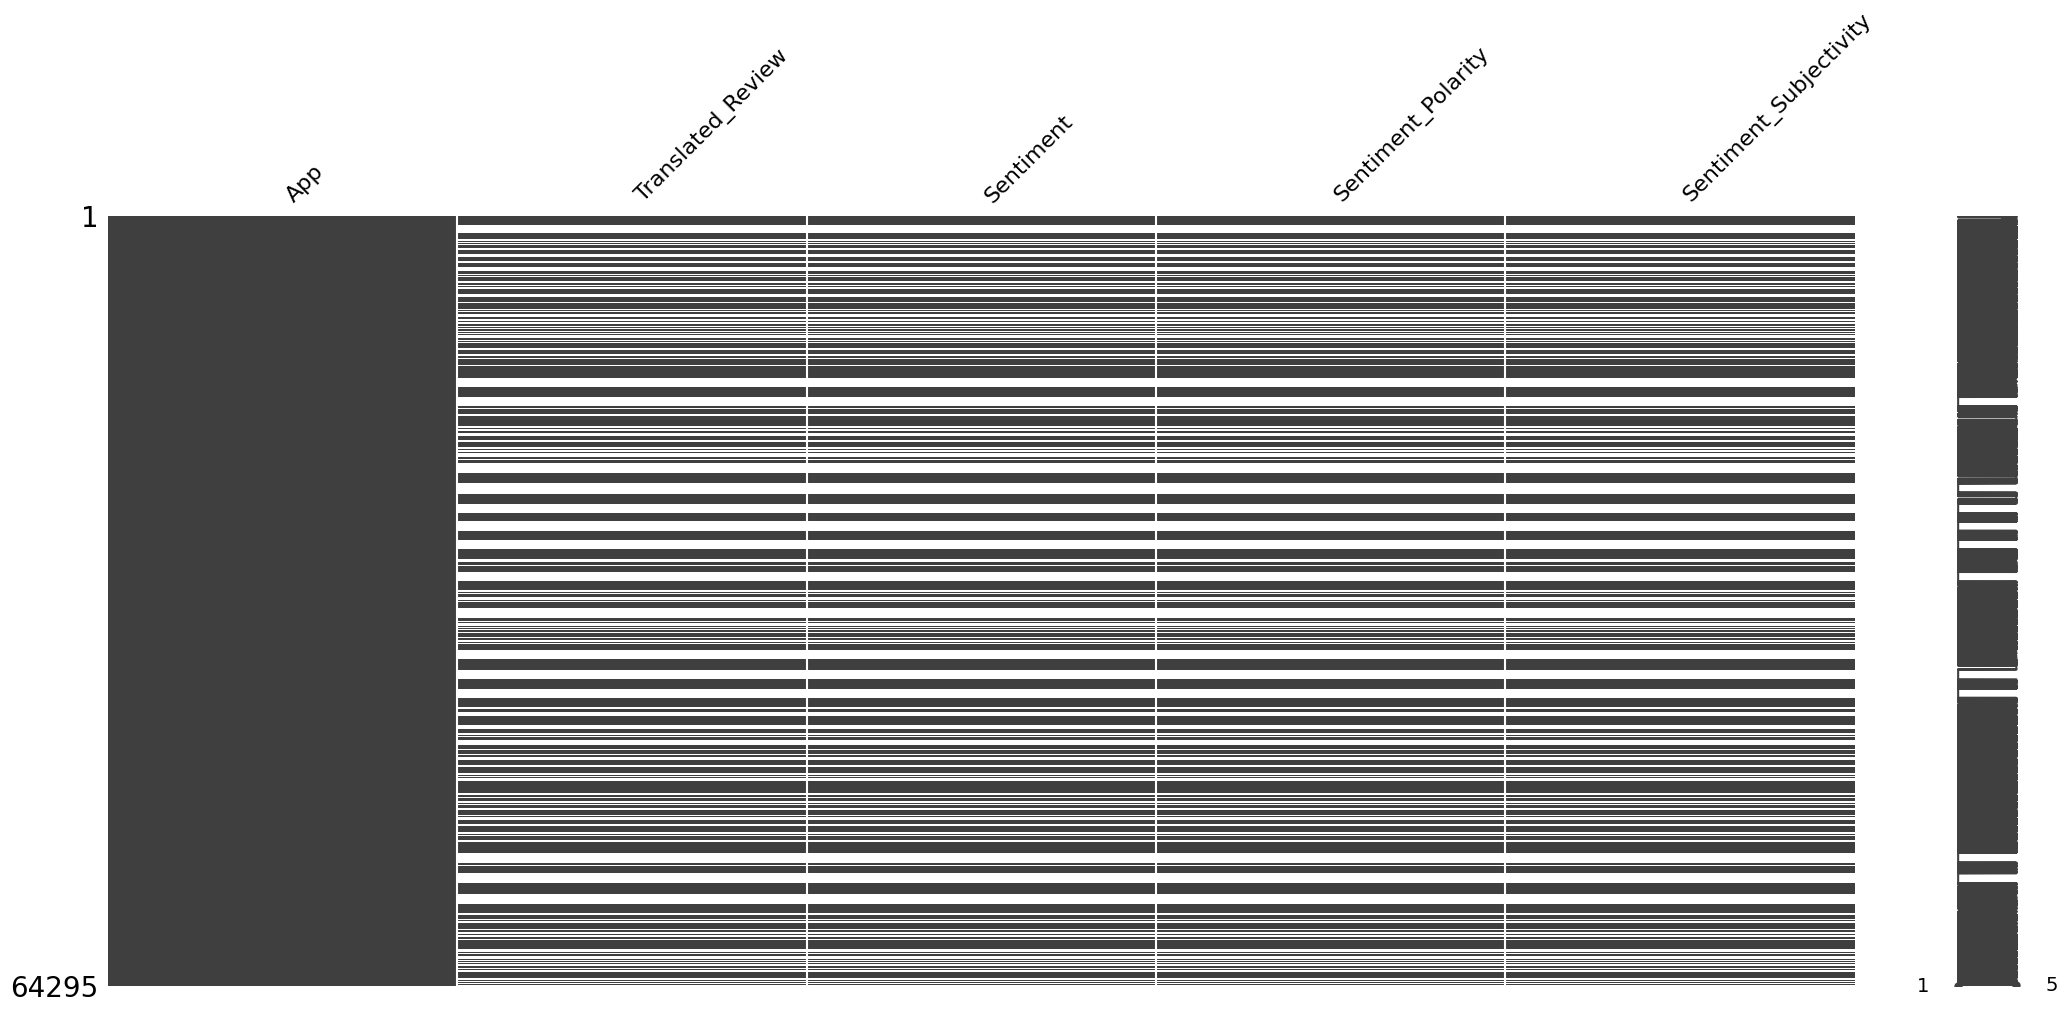

In [690]:
msno.matrix(reviews_data)
plt.show()

Com podem observar, hi ha una forta dependència entre els atributs *Translated_Review*, *Sentiment*, *Sentiment_Polarity* i *Sentiment_Subjectivity* pel que fa als valors nuls. Entenem que la causa de tot això és l'atribut *Translated_Review*, ja que l'ànalisi del sentiment requereix que l'usuari hagi escrit un text per a la seva ressenya. Podem concloure, que els valors nuls en aquest cas tenen un significat concret.

Per entrar més en detall, crearem un gràfic que mostri el percentatge de valors nuls en els comentaris de determinades aplicacions (per qüestions d'espai), en funció del nombre total de comentaris de cada una.

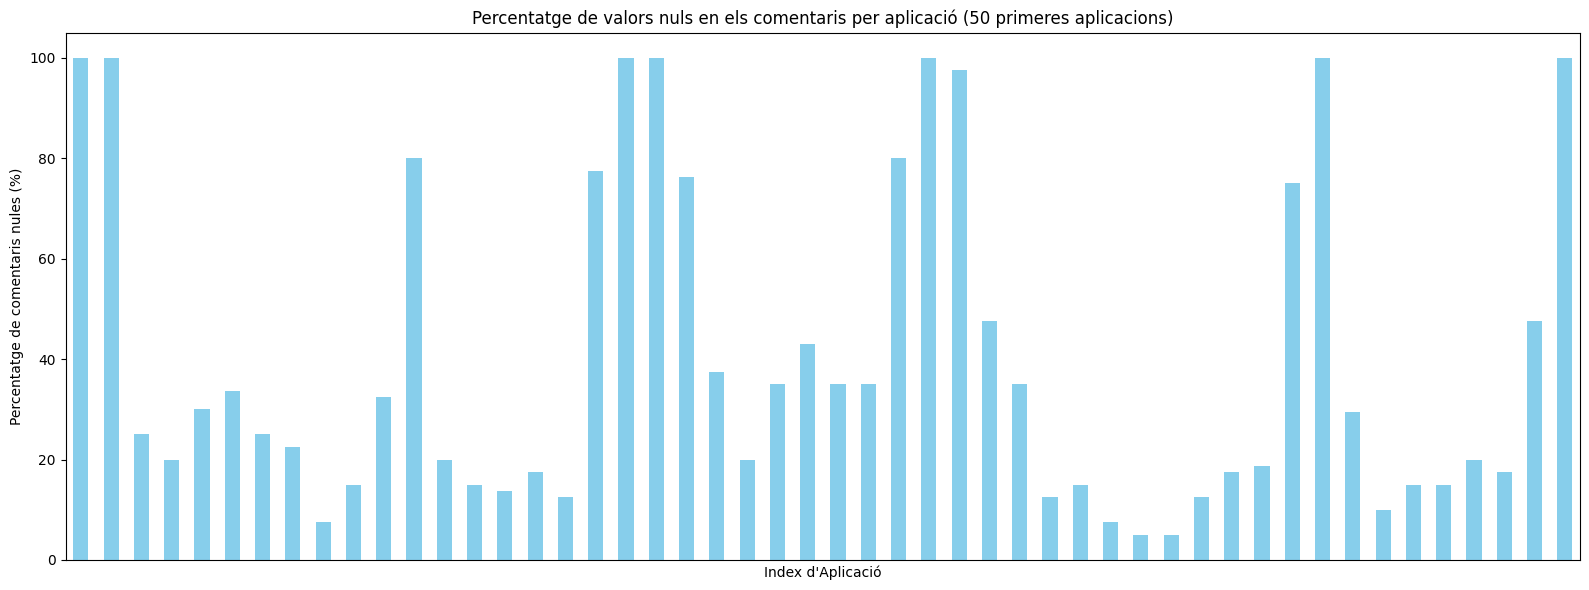

In [ ]:
grouped_data = reviews_data.groupby('App')
nans_in_reviews = grouped_data['Translated_Review'].agg(lambda x: x.isna().sum())
total_reviews = grouped_data['Translated_Review'].count() + nans_in_reviews
nan_percentage = (nans_in_reviews / total_reviews) * 100

subset_nan_percentage = nan_percentage.tail(50)

plt.figure(figsize=(16, 6))
subset_nan_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentatge de valors nuls en els comentaris per aplicació (50 primeres aplicacions)')
plt.xlabel('Index d\'Aplicació')
plt.ylabel('Percentatge de comentaris nules (%)')
plt.xticks([])  

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.3)  
plt.tight_layout()
plt.show()

Segons el gràfic, podem observar que un nombre alt d'aplicacions no contenen comentaris. Per quantificar-ho millor, a continuació calcularem el percentatge d'aplicacions que no contenen comentaris segons el total d'aplicacions en el dataset *reviews*:

In [692]:
aplicacions_sense_resenyes = (nan_percentage == 100).sum()
total_aplicacions = len(nan_percentage)
percentatge_sense_resenyes = (aplicacions_sense_resenyes / total_aplicacions) * 100
percentatge_sense_resenyes = round(percentatge_sense_resenyes, 2)
print(f'Percentatge d\'aplicacions sense ressenyes: {percentatge_sense_resenyes}%')

Percentatge d'aplicacions sense ressenyes: 19.46%


Segons el càlcul anterior, el 19% d'aplicacions no contenen comentaris.

### 5.3. Detecció de dades anomals

En aquest apartat, comprovarem que els atributs no tinguin valors anòmals (*outliers*) que no hàgim detectat a primera vista. Començarem verificant els atributs categòrics, i posteriorment passarem als numèrics.  

**1. Atributs categòrics: 🏷️** 

- **App:** Comprovarem que tot nom d'aplicació del dataset *reviews* estigui present en el conjunt de dades *apps*. En percentatge expressarem el nombre d'aplicacions del dataset *reviews* que no estiguin present en el dataset *apps*. 

In [693]:
apps_set = set(apps_data['App'])
reviews_set = set(reviews_data['App'])
missing_apps = apps_set - reviews_set
missing_apps_count = len(missing_apps)
print(f"{(missing_apps_count / len(apps_set)) * 100:.2f}%")

89.44%


Segons el resultat anterior, podem veure que hi han aplicacions en el dataset *ressenyes* que no estan contingudes en el dataset *apps*, concretament un 89%.


- **Sentiment:** Verificarem que no tinguem una categoria anòmala, o una categoria que no s'hagi contemplat a primera vista.

In [694]:
sentiment_counts = reviews_data['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
Positive    23998
Negative     8271
Neutral      5163
Name: count, dtype: int64


En aquest cas tenim les categories Positive, Negative i Neutral. No s'observa ningun cas extrany. 

**1. Atributs numèrics: 🔢** 
- **Sentiment_Polarity, Sentiment_Subjectivity:** Verificarem que no tinguem presents valors fora de rang dels respectius atributs. 

In [695]:
polarity_summary = reviews_data['Sentiment_Polarity'].describe()
subjectivity_summary = reviews_data['Sentiment_Subjectivity'].describe()

print(f"Sentiment_Polarity - Min: {polarity_summary['min']}, Max: {polarity_summary['max']}")
print(f"Sentiment_Subjectivity - Min: {subjectivity_summary['min']}, Max: {subjectivity_summary['max']}")

Sentiment_Polarity - Min: -1.0, Max: 1.0
Sentiment_Subjectivity - Min: 0.0, Max: 1.0


Podem comprovar pels dos atributs, que no ens apareix ningun valor fora de rang

### 5.4. Correlació d'atributs

En aquesta secció, veurem com de correlacionats estan els atributs numèrics del dataset *reviews* amb relació al atribut objectiu, com s'ha dit, el nombre de descargues d'una aplicació. Per aconseguir-ho, calcularem la mitjana del *Sentiment_Polarity* i el *Sentiment_Subjectivity* per cada aplicació.

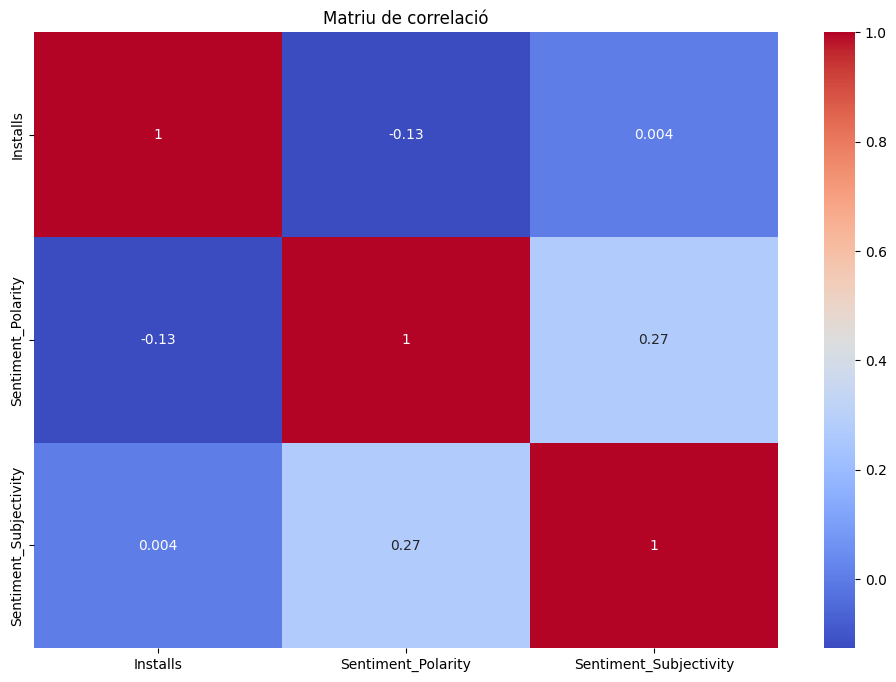

In [696]:
apps_data_temp = apps_data[['App', 'Installs']].copy()
apps_data_temp['Installs'] = pd.to_numeric(apps_data_temp['Installs'].replace({',': '', r'\+': ''}, regex=True), errors='coerce')

# Neteja de dades en reviews_data i càlcul de mitjanes
reviews_data.dropna(subset=['Sentiment_Polarity', 'Sentiment_Subjectivity'], inplace=True)
reviews_grouped = reviews_data.groupby('App', as_index=False).agg({'Sentiment_Polarity': 'mean', 'Sentiment_Subjectivity': 'mean'})

merged_data = pd.merge(apps_data_temp, reviews_grouped, on='App', how='inner')
corr_matrix = merged_data.drop(columns=['App']).corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriu de correlació')
plt.show()

Podem veure que l'atribut *Sentiment_Subjectivity* no té practicament ninguna correlació amb el nombre de descargues. En canvi, per l'atribut *Sentiment_Polarity* té una correlació més alta, concretament del 27%. 